In [20]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd

In [11]:
np.random.seed(0)

## Data Visualisation

In [12]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [13]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)  
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

In [14]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [15]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [16]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

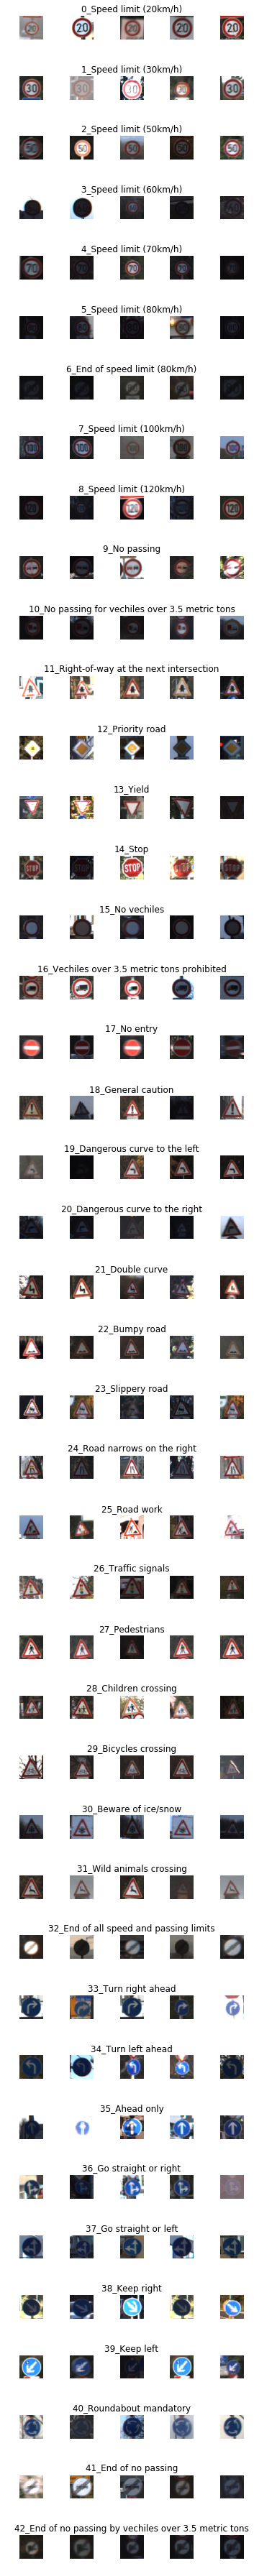

In [18]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))
            
            

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

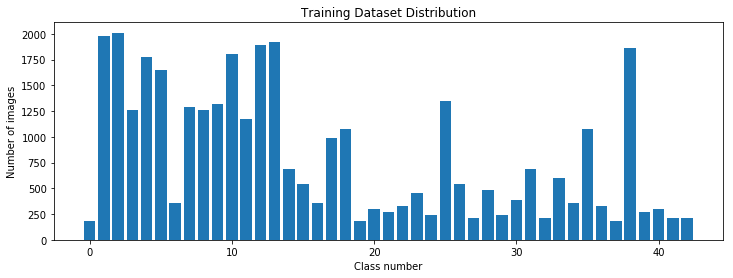

In [19]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Training Dataset Distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")

## Preprocessing the training images

(32, 32, 3)
36


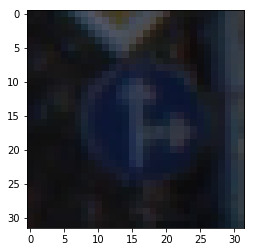

In [24]:
plt.imshow(X_train[1000])
print(X_train[1000].shape)
print(y_train[1000])

In [27]:
def grayscale(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image

(32, 32)


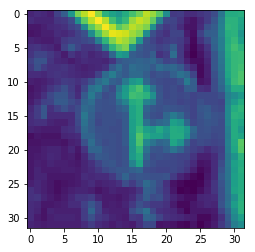

In [29]:
img = grayscale(X_train[1000])
plt.imshow(img)
print(img.shape)